In [1]:
# Загрузка данных

!wget  -O 'train.csv' -q 'https://www.dropbox.com/scl/fi/p7lnv47f4uzw72175sfxx/toxic_train.csv?rlkey=2jwza1zguskr2gtd33tjv02em&dl=0'
!wget  -O 'test.csv' -q 'https://www.dropbox.com/scl/fi/j0j91smtmy5t5gcnk8elf/toxic_test.csv?rlkey=tf9163uciktrdllpcj2h2clht&dl=0'

In [121]:
import time
import numpy as np
import scipy


class BaseSmoothOracle:
    """
    Базовый класс для реализации оракулов.
    """

    def func(self, w):
        """
        Вычислить значение функции в точке w.
        """
        raise NotImplementedError('Func oracle is not implemented.')

    def grad(self, w):
        """
        Вычислить значение градиента функции в точке w.
        """
        raise NotImplementedError('Grad oracle is not implemented.')


class BinaryLogistic(BaseSmoothOracle):
    """
    Оракул для задачи двухклассовой логистической регрессии.

    Оракул должен поддерживать l2 регуляризацию.
    """

    def __init__(self, l2_coef):
        """
        Задание параметров оракула.

        l2_coef - коэффициент l2 регуляризации
        """
        self.l2_coef = l2_coef

    def func(self, X, y, w):
        """
        Вычислить значение функционала в точке w на выборке X с ответами y.

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        y - одномерный numpy array

        w - одномерный numpy array
        """
        w = np.array([w])
        y = np.array([y])
        M = X @ w.T
        Q = (np.logaddexp(0, -y.T * M)).sum() / y.shape[1]
        l2 = 0.5 * self.l2_coef * (w.T ** 2).sum()
        return Q + l2

    def grad(self, X, y, w):
        """
        Вычислить градиент функционала в точке w на выборке X с ответами y.

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        y - одномерный numpy array

        w - одномерный numpy array
        """
        w = np.array([w])
        y = np.array([y])
        M = X @ w.T
        denominator = (1 + np.exp(y.T * M))
        if isinstance(X, np.ndarray):
            ans = -1 / y.shape[1] * (1 / denominator * (y.T) * X).sum(axis=0)
        else:
            ans = -1 / y.shape[1] * (X.multiply(1 / denominator * (y.T)).toarray()).sum(axis=0)
        return np.array([ans]).T + self.l2_coef * w.T


class GDClassifier:
    """
    Реализация метода градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """

    def __init__(
        self, loss_function, step_alpha=1, step_beta=0,
        tolerance=1e-5, max_iter=1000, **kwargs
    ):
        """
        loss_function - строка, отвечающая за функцию потерь классификатора.
        Может принимать значения:
        - 'binary_logistic' - бинарная логистическая регрессия

        step_alpha - float, параметр выбора шага из текста задания

        step_beta- float, параметр выбора шага из текста задания

        tolerance - точность, по достижении которой, необходимо прекратить оптимизацию.
        Необходимо использовать критерий выхода по модулю разности соседних значений функции:
        если |f(x_{k+1}) - f(x_{k})| < tolerance: то выход

        max_iter - максимальное число итераций

        **kwargs - аргументы, необходимые для инициализации
        """
        if loss_function != 'binary_logistic':
            raise TypeError
        self.loss_function = BinaryLogistic(kwargs['l2_coef'])
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.kwargs = kwargs

    def fit(self, X, y, w_0=None, trace=False):
        """
        Обучение метода по выборке X с ответами y

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        y - одномерный numpy array

        w_0 - начальное приближение в методе

        trace - переменная типа bool

        Если trace = True, то метод должен вернуть словарь history, содержащий информацию
        о поведении метода. Длина словаря history = количество итераций + 1 (начальное приближение)

        history['time']: list of floats, содержит интервалы времени между двумя итерациями метода
        history['func']: list of floats, содержит значения функции на каждой итерации
        (0 для самой первой точки)
        """
        self.w = np.array([w_0]).T
        history = {'time': [0], 'func': [self.loss_function.func(X, y, self.w.T[0])]}
        #history = {'time': [0], 'func': [self.loss_function.func(X, y, self.w.T[0])], 'accuracy': [accuracy_score(y_test, self.predict(X_test_matrix))]}
        self.w = np.array([w_0]).T
        last_time = time.time()
        for i in range(1, self.max_iter + 1):
            if i != 1 and abs(history['func'][-1] - history['func'][-2]) <= self.tolerance:
                break
            grad = self.loss_function.grad(X, y, self.w.T[0])
            self.w -= self.step_alpha / i ** self.step_beta * grad
            history["func"].append(self.loss_function.func(X, y, self.w.T[0]))
            history["time"].append(time.time() - last_time)
            #history["accuracy"].append(accuracy_score(y_test, self.predict(X_test_matrix)))
            last_time = time.time()
        if trace:
            return history

    def predict(self, X):
        """
        Получение меток ответов на выборке X

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        return: одномерный numpy array с предсказаниями
        """
        return 2 * (X @ self.w >= 0.5) - 1

    def predict_proba(self, X):
        """
        Получение вероятностей принадлежности X к классу k

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        return: двумерной numpy array, [i, k] значение соответветствует вероятности
        принадлежности i-го объекта к классу k
        """
        a = scipy.special.expit(X @ self.w)
        return np.concatenate((1 - a, a), axis=1)

    def get_objective(self, X, y):
        """
        Получение значения целевой функции на выборке X с ответами y

        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array

        return: float
        """
        return self.loss_function.func(X, y, self.w)

    def get_gradient(self, X, y):
        """
        Получение значения градиента функции на выборке X с ответами y

        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array

        return: numpy array, размерность зависит от задачи
        """
        return self.loss_function.grad(X, y, self.w)

    def get_weights(self):
        """
        Получение значения весов функционала
        """
        return self.w


class SGDClassifier(GDClassifier):
    """
    Реализация метода стохастического градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """

    def __init__(
        self, loss_function, batch_size, step_alpha=1, step_beta=0,
        tolerance=1e-5, max_iter=1000, random_seed=153, **kwargs
    ):
        """
        loss_function - строка, отвечающая за функцию потерь классификатора.
        Может принимать значения:
        - 'binary_logistic' - бинарная логистическая регрессия

        batch_size - размер подвыборки, по которой считается градиент

        step_alpha - float, параметр выбора шага из текста задания

        step_beta- float, параметр выбора шага из текста задания

        tolerance - точность, по достижении которой, необходимо прекратить оптимизацию
        Необходимо использовать критерий выхода по модулю разности соседних значений функции:
        если |f(x_{k+1}) - f(x_{k})| < tolerance: то выход

        max_iter - максимальное число итераций (эпох)

        random_seed - в начале метода fit необходимо вызвать np.random.seed(random_seed).
        Этот параметр нужен для воспроизводимости результатов на разных машинах.

        **kwargs - аргументы, необходимые для инициализации
        """
        if loss_function != 'binary_logistic':
            raise TypeError
        self.loss_function = BinaryLogistic(kwargs['l2_coef'])
        self.batch_size = batch_size
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_seed = random_seed
        self.kwargs = kwargs

    def fit(self, X, y, w_0=None, trace=False, log_freq=1):
        """
        Обучение метода по выборке X с ответами y

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        y - одномерный numpy array

        w_0 - начальное приближение в методе

        Если trace = True, то метод должен вернуть словарь history, содержащий информацию
        о поведении метода. Если обновлять history после каждой итерации, метод перестанет
        превосходить в скорости метод GD. Поэтому, необходимо обновлять историю метода лишь
        после некоторого числа обработанных объектов в зависимости от приближённого номера эпохи.
        Приближённый номер эпохи:
            {количество объектов, обработанных методом SGD} / {количество объектов в выборке}

        log_freq - float от 0 до 1, параметр, отвечающий за частоту обновления.
        Обновление должно проиходить каждый раз, когда разница между двумя значениями приближённого номера эпохи
        будет превосходить log_freq.

        history['epoch_num']: list of floats, в каждом элементе списка будет записан приближённый номер эпохи:
        history['time']: list of floats, содержит интервалы времени между двумя соседними замерами
        history['func']: list of floats, содержит значения функции после текущего приближённого номера эпохи
        history['weights_diff']: list of floats, содержит квадрат нормы разности векторов весов с соседних замеров
        (0 для самой первой точки)
        """
        np.random.seed(self.random_seed)
        self.w = np.array([w_0]).T
        self.prev_w = np.array([w_0]).T
        prev_loss = 10e9
        #history = {'time': [0],'func': [self.loss_function.func(X, y, self.w.T[0])], 'epoch_num': [0], 'weights_diff': [0], 'accuracy': [accuracy_score(y_test, self.predict(X_test_matrix))]}
        history = {'time': [0],'func': [self.loss_function.func(X, y, self.w.T[0])], 'epoch_num': [0], 'weights_diff': [0]}
        last_time = time.time()
        prev_epoch_num, epoch_num = 0, 0
        for i in range(1, self.max_iter + 1):
            if (len(history['func']) > 1) and abs(history['func'][-1] - history['func'][-2]) <= self.tolerance or (abs(self.loss_function.func(X, y, self.w.T[0])- prev_loss) <= self.tolerance):
                break
            prev_loss = self.loss_function.func(X, y, self.w.T[0])
            new_ind = np.arange(X.shape[0])
            np.random.shuffle(new_ind)
            X_new = X[new_ind]
            y_new = y[new_ind]
            for j in range(0, X.shape[0], self.batch_size):
                X_batch = X_new[j:j + self.batch_size]
                y_batch = y_new[j:j + self.batch_size]
                grad = self.loss_function.grad(X_batch, y_batch, self.w.T[0])
                self.w -= self.step_alpha / i ** self.step_beta * grad
                epoch_num += self.batch_size / X.shape[0]
                if not trace:
                    continue
                if epoch_num - prev_epoch_num >= log_freq:
                    history["epoch_num"].append(epoch_num)
                    prev_epoch_num = epoch_num
                    history["time"].append(time.time() - last_time)
                    last_time = time.time()
                    history["func"].append(self.loss_function.func(X, y, self.w.T[0]))
                    history["weights_diff"].append(((self.prev_w.T[0] - self.w.T[0]) ** 2).sum())
                    #history["accuracy"].append(accuracy_score(y_test, self.predict(X_test_matrix)))
                    self.prev_w = self.w.copy()
        if trace:
            return history

        


In [90]:
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,Unnamed: 0,comment_text,is_toxic
0,0,Explanation\nWhy the edits made under my usern...,False
1,1,D'aww! He matches this background colour I'm s...,False
2,2,"Hey man, I'm really not trying to edit war. It...",False
3,3,"""\nMore\nI can't make any real suggestions on ...",False
4,4,"You, sir, are my hero. Any chance you remember...",False


In [91]:
# EXP 1

def only_letters_and_numbers(s):
    answer = ''
    for x in s:
        if x.isalnum():
            answer += x
        else:
            answer += ' '
    return answer

# перевод в нижний регистр
train.comment_text = train.comment_text.str.lower()
test.comment_text = test.comment_text.str.lower()

# замена не букв и не цифр на пробелы
for i in train.index:
    train["comment_text"][i] = only_letters_and_numbers(train["comment_text"][i])
for i in test.index:
    test["comment_text"][i] = only_letters_and_numbers(test["comment_text"][i])
train.head()

/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/783881327.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["comment_text"][i] = only_letters_and_numbers(train["comment_text"][i])
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/783881327.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["comment_text"][i] = only_letters_and_numbers(test["comment_text"][i])


,Unnamed: 0,comment_text,is_toxic
0,0,explanation why the edits made under my userna...,False
1,1,d aww he matches this background colour i m s...,False
2,2,hey man i m really not trying to edit war it...,False
3,3,more i can t make any real suggestions on im...,False
4,4,you sir are my hero any chance you remember...,False


In [92]:
# EXP 2
from sklearn.feature_extraction.text import CountVectorizer


vectorizer = CountVectorizer(max_df=0.99, min_df=0.01)
X_train_matrix = vectorizer.fit_transform(train["comment_text"])
X_test_matrix = vectorizer.transform(test["comment_text"])
print(X_train_matrix.shape)

(52061, 568)


In [12]:
# EXP 3
y_train = 2 * train["is_toxic"] - 1
y_test = 2 * test["is_toxic"] - 1
y_train = y_train.values
y_test = y_test.values
def grad_num(f, w, delta):
    answer = []
    for i in range(w.shape[0]):
        tmp = np.zeros((w.shape[0],))
        tmp[i] = delta
        answer.append((f(w + tmp) - f(w)) / delta)
    return answer

def grad(X, y, w, l2_coef):
    w = np.array([w])
    y = np.array([y])
    M = X @ w.T
    denominator = (1 + np.exp(y.T * M))
    if isinstance(X, np.ndarray):
        ans = -1 / y.shape[1] * (1 / denominator * (y.T) * X).sum(axis=0)
    else:
        ans = -1 / y.shape[1] * (X.multiply(1 / denominator * (y.T)).toarray()).sum(axis=0)
    return (np.array([ans]).T + l2_coef * w.T).T[0]

def func(w):
    global y_train
    global X_train_matrix
    X = X_train_matrix
    w = np.array([w])
    y = np.array([y_train])
    M = X @ w.T
    Q = (np.logaddexp(0, -y.T * M)).sum() / y.shape[1]
    l2 = 0.5 * (w.T ** 2).sum()
    return Q + l2
    

In [18]:
w = np.zeros(X_train_matrix.shape[1])
start1 = time.time()
analit = grad(X_train_matrix, y_train, w, 1)
print('Аналитически (сек): ', time.time() - start1)
start2 = time.time()
numerical = grad_num(func, w, 0.0000001)
print('Численно (сек): ', time.time() - start2)
print(np.mean(np.abs(analit - numerical) / (np.abs(analit) + np.abs(numerical))))
print(np.abs(analit - numerical).sum() / np.abs(analit + numerical).sum())

Аналитически (сек):  0.055278778076171875
Численно (сек):  2.498965263366699
8.932377264308049e-06
1.535127345581641e-06


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/1676414869.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))


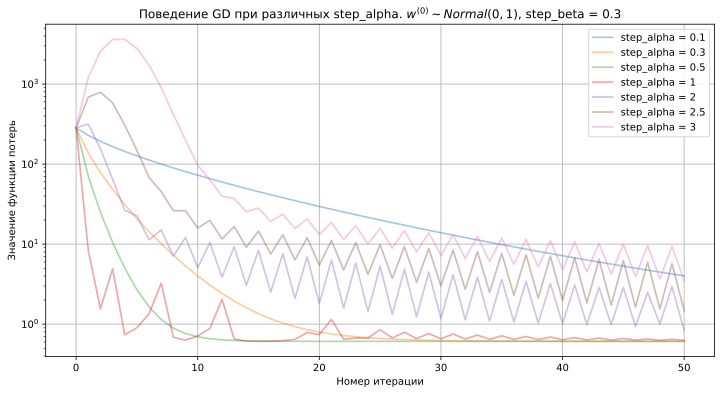

In [25]:
# EXP 4
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(12, 6))
plt.title("Поведение GD при различных step_alpha. $w^{(0)} \sim Normal(0, 1)$, step_beta = 0.3")
plt.ylabel("Значение функции потерь")
plt.xlabel("Номер итерации")
plt.yscale('log')
plt.grid(True)

weight=np.random.normal(loc=0, scale=1,size=X_train_matrix.shape[1])
for alpha in [0.1, 0.3, 0.5, 1, 2, 2.5, 3]:
    model = GDClassifier('binary_logistic', l2_coef=1, step_alpha=alpha, step_beta=0.3, max_iter=50, tolerance = 0.0000000001)
    history = model.fit(X_train_matrix, y_train, w_0=weight, trace=True)
    prediction = model.predict(X_test_matrix)
    plt.plot(np.arange(51), history["func"], label=f"step_alpha = {alpha}", linewidth=1.7, alpha=0.4)
    plt.legend(loc="upper right")
plt.savefig('1.pdf', bbox_inches='tight')
plt.show()

/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folde

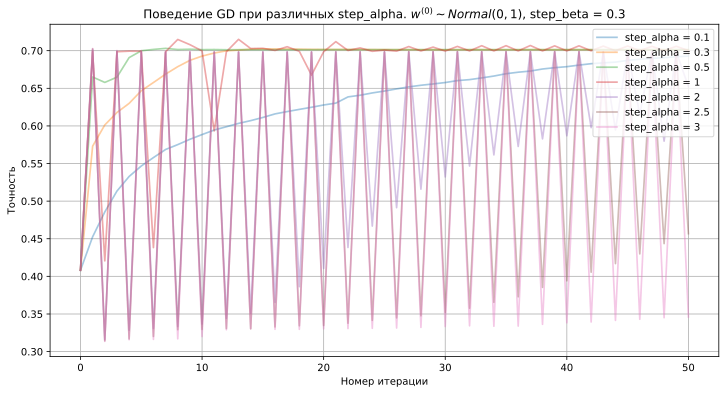

In [33]:
from matplotlib import pyplot
pyplot.figure(figsize=(12, 6))
plt.title("Поведение GD при различных step_alpha. $w^{(0)} \sim Normal(0, 1)$, step_beta = 0.3")
plt.ylabel("Точность")
plt.xlabel("Номер итерации")
pyplot.grid(True)
from sklearn.metrics import accuracy_score
loss = []
accuracy = []
weight=np.random.normal(loc=0, scale=1,size=X_train_matrix.shape[1])
for alpha in [0.1, 0.3, 0.5, 1, 2, 2.5, 3]:
    grad_desc = GDClassifier('binary_logistic', l2_coef=1, step_alpha=alpha, step_beta=0.3, max_iter=50, tolerance = 0.0000000001)
    history = grad_desc.fit(X_train_matrix, y_train, w_0=weight, trace=True)
    prediction = grad_desc.predict(X_test_matrix)
    plt.plot(np.arange(51), history["accuracy"], label=f"step_alpha = {alpha}", linewidth=1.7, alpha=0.4)
    plt.legend(loc="upper right")
plt.savefig('2.pdf', bbox_inches='tight')
plt.show()

/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folde

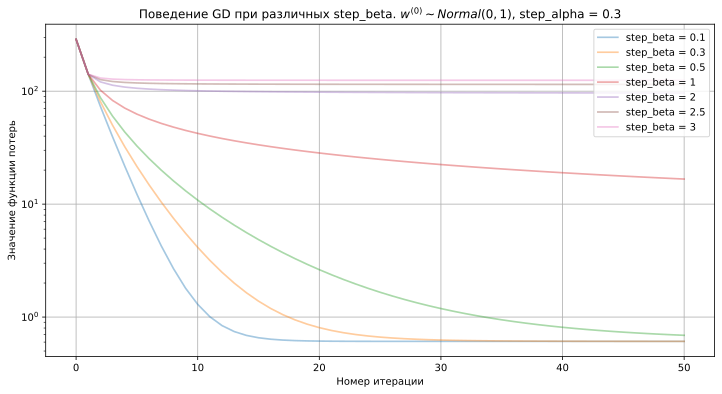

In [39]:
pyplot.figure(figsize=(12, 6))
plt.title("Поведение GD при различных step_beta. $w^{(0)} \sim Normal(0, 1)$, step_alpha = 0.3")
plt.ylabel("Значение функции потерь")
plt.xlabel("Номер итерации")
plt.yscale('log')
pyplot.grid(True)

weight=np.random.normal(loc=0, scale=1,size=X_train_matrix.shape[1])
for beta in [0.1, 0.3, 0.5, 1, 2, 2.5, 3]:
    grad_desc = GDClassifier('binary_logistic', l2_coef=1, step_alpha=0.3, step_beta=beta, max_iter=50, tolerance = 0.0000000001)
    history = grad_desc.fit(X_train_matrix, y_train, w_0=weight, trace=True)
    prediction = grad_desc.predict(X_test_matrix)
    plt.plot(np.arange(51), history["func"], label=f"step_beta = {beta}", linewidth=1.7, alpha=0.4)
    plt.legend(loc="upper right")
plt.savefig('3.pdf', bbox_inches='tight')
plt.show()

/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folde

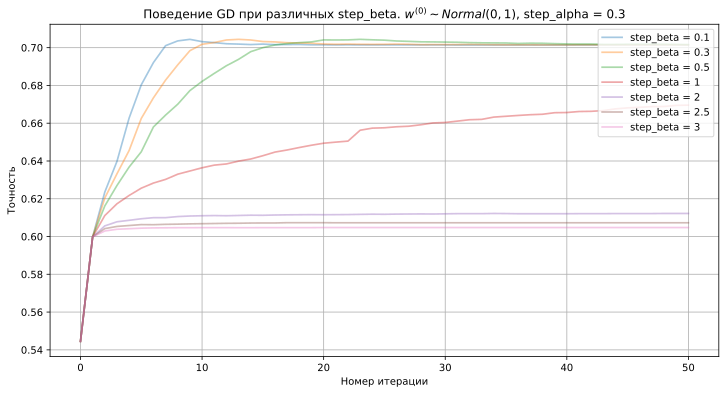

In [41]:
from matplotlib import pyplot as plt
pyplot.figure(figsize=(12, 6))
plt.title("Поведение GD при различных step_beta. $w^{(0)} \sim Normal(0, 1)$, step_alpha = 0.3")
plt.ylabel("Точность")
plt.xlabel("Номер итерации")
pyplot.grid(True)

loss = []
accuracy = []
weight=np.random.normal(loc=0, scale=1,size=X_train_matrix.shape[1])
for beta in [0.1, 0.3, 0.5, 1, 2, 2.5, 3]:
    grad_desc = GDClassifier('binary_logistic', l2_coef=1, step_alpha=0.3, step_beta=beta, max_iter=50, tolerance = 0.0000000001)
    history = grad_desc.fit(X_train_matrix, y_train, w_0=weight, trace=True)
    prediction = grad_desc.predict(X_test_matrix)
    plt.plot(np.arange(51), history["accuracy"], label=f"step_beta = {beta}", linewidth=1.7, alpha=0.4)
    plt.legend(loc="upper right")
plt.savefig('4.pdf', bbox_inches='tight')
plt.show()

/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))


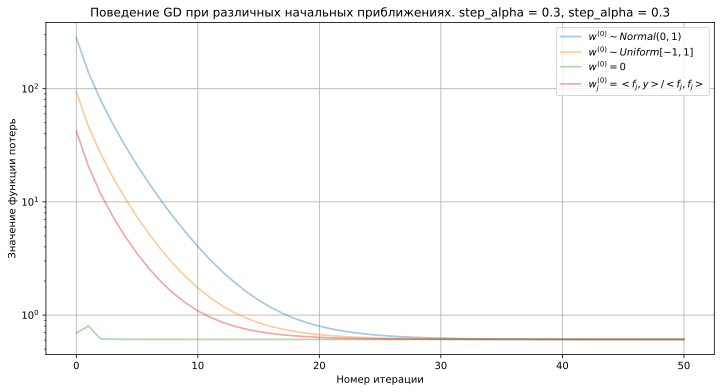

In [42]:
from matplotlib import pyplot as plt
pyplot.figure(figsize=(12, 6))
plt.title("Поведение GD при различных начальных приближениях. step_alpha = 0.3, step_alpha = 0.3")
plt.ylabel("Значение функции потерь")
plt.xlabel("Номер итерации")
plt.yscale('log')
pyplot.grid(True)

loss = []
accuracy = []

grad_desc = GDClassifier('binary_logistic', l2_coef=1, step_alpha=0.3, step_beta=0.3, max_iter=50, tolerance = 0.0000000001)
history = grad_desc.fit(X_train_matrix, y_train, w_0=np.random.normal(loc=0, scale=1,size=X_train_matrix.shape[1]), trace=True)
prediction = grad_desc.predict(X_test_matrix)
plt.plot(np.arange(51), history["func"], label="$w^{(0)} \sim Normal(0, 1)$", linewidth=1.7, alpha=0.4)
plt.legend(loc="upper right")

grad_desc = GDClassifier('binary_logistic', l2_coef=1, step_alpha=0.3, step_beta=0.3, max_iter=50, tolerance = 0.0000000001)
history = grad_desc.fit(X_train_matrix, y_train, w_0=np.random.uniform(low=-1, high=1,size=X_train_matrix.shape[1]), trace=True)
prediction = grad_desc.predict(X_test_matrix)
plt.plot(np.arange(51), history["func"], label="$w^{(0)} \sim Uniform[-1, 1]$", linewidth=1.7, alpha=0.4)
plt.legend(loc="upper right")

grad_desc = GDClassifier('binary_logistic', l2_coef=1, step_alpha=0.3, step_beta=0.3, max_iter=50, tolerance = 0.0000000001)
history = grad_desc.fit(X_train_matrix, y_train, w_0=np.zeros(X_train_matrix.shape[1]), trace=True)
prediction = grad_desc.predict(X_test_matrix)
plt.plot(np.arange(51), history["func"], label="$w^{(0)} = 0$", linewidth=1.7, alpha=0.4)
plt.legend(loc="upper right")

grad_desc = GDClassifier('binary_logistic', l2_coef=1, step_alpha=0.3, step_beta=0.3, max_iter=50, tolerance = 0.0000000001)
weight=np.zeros(X_train_matrix.shape[1])
for j in range(X_train_matrix.shape[1]):
  weight[j] = np.dot(X_train_matrix[:, j].toarray().T[0], y_train) / np.dot(X_train_matrix[:, j].toarray().T[0], X_train_matrix[:, j].toarray().T[0])
history = grad_desc.fit(X_train_matrix, y_train, w_0=weight, trace=True)
prediction = grad_desc.predict(X_test_matrix)
plt.plot(np.arange(51), history["func"], label="$w^{(0)}_j = <f_j, y> / <f_j, f_j>$", linewidth=1.7, alpha=0.4)
plt.legend(loc="upper right")

plt.savefig('5.pdf', bbox_inches='tight')
plt.show()

/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))


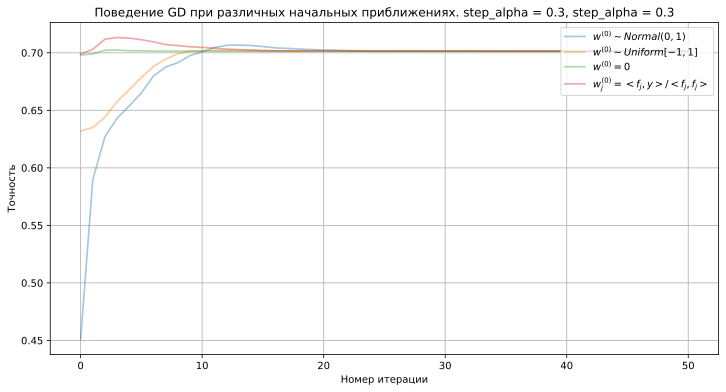

In [43]:
from matplotlib import pyplot as plt
pyplot.figure(figsize=(12, 6))
plt.title("Поведение GD при различных начальных приближениях. step_alpha = 0.3, step_alpha = 0.3")
plt.ylabel("Точность")
plt.xlabel("Номер итерации")
# plt.yscale('log')
pyplot.grid(True)

loss = []
accuracy = []

grad_desc = GDClassifier('binary_logistic', l2_coef=1, step_alpha=0.3, step_beta=0.3, max_iter=50, tolerance = 0.0000000001)
history = grad_desc.fit(X_train_matrix, y_train, w_0=np.random.normal(loc=0, scale=1,size=X_train_matrix.shape[1]), trace=True)
prediction = grad_desc.predict(X_test_matrix)
plt.plot(np.arange(51), history["accuracy"], label="$w^{(0)} \sim Normal(0, 1)$", linewidth=1.7, alpha=0.4)
plt.legend(loc="upper right")

grad_desc = GDClassifier('binary_logistic', l2_coef=1, step_alpha=0.3, step_beta=0.3, max_iter=50, tolerance = 0.0000000001)
history = grad_desc.fit(X_train_matrix, y_train, w_0=np.random.uniform(low=-1, high=1,size=X_train_matrix.shape[1]), trace=True)
prediction = grad_desc.predict(X_test_matrix)
plt.plot(np.arange(51), history["accuracy"], label="$w^{(0)} \sim Uniform[-1, 1]$", linewidth=1.7, alpha=0.4)
plt.legend(loc="upper right")

grad_desc = GDClassifier('binary_logistic', l2_coef=1, step_alpha=0.3, step_beta=0.3, max_iter=50, tolerance = 0.0000000001)
history = grad_desc.fit(X_train_matrix, y_train, w_0=np.zeros(X_train_matrix.shape[1]), trace=True)
prediction = grad_desc.predict(X_test_matrix)
plt.plot(np.arange(51), history["accuracy"], label="$w^{(0)} = 0$", linewidth=1.7, alpha=0.4)
plt.legend(loc="upper right")

grad_desc = GDClassifier('binary_logistic', l2_coef=1, step_alpha=0.3, step_beta=0.3, max_iter=50, tolerance = 0.0000000001)
weight=np.zeros(X_train_matrix.shape[1])
for j in range(X_train_matrix.shape[1]):
  weight[j] = np.dot(X_train_matrix[:, j].toarray().T[0], y_train) / np.dot(X_train_matrix[:, j].toarray().T[0], X_train_matrix[:, j].toarray().T[0])
history = grad_desc.fit(X_train_matrix, y_train, w_0=weight, trace=True)
prediction = grad_desc.predict(X_test_matrix)
plt.plot(np.arange(51), history["accuracy"], label="$w^{(0)}_j = <f_j, y> / <f_j, f_j>$", linewidth=1.7, alpha=0.4)
plt.legend(loc="upper right")

plt.savefig('6.pdf', bbox_inches='tight')
plt.show()

/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folde

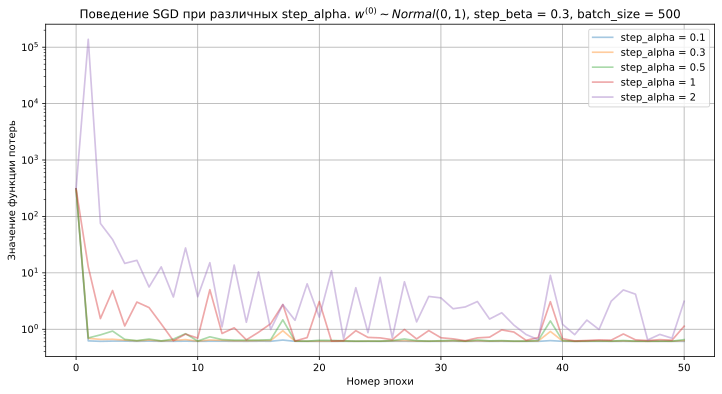

In [44]:
# Графики 5
pyplot.figure(figsize=(12, 6))
plt.title("Поведение SGD при различных step_alpha. $w^{(0)} \sim Normal(0, 1)$, step_beta = 0.3, batch_size = 500")
plt.ylabel("Значение функции потерь")
plt.xlabel("Номер эпохи")
plt.yscale('log')
pyplot.grid(True)

loss = []
accuracy = []
weight=np.random.normal(loc=0, scale=1,size=X_train_matrix.shape[1])
for alpha in [0.1, 0.3, 0.5, 1, 2]:
    grad_desc = SGDClassifier('binary_logistic', l2_coef=1, batch_size = 500, step_alpha=alpha, step_beta=0.3, max_iter=50, tolerance = 0.0000000001, random_seed=153)
    history = grad_desc.fit(X_train_matrix, y_train, w_0=weight, trace=True)
    prediction = grad_desc.predict(X_test_matrix)
    plt.plot(np.arange(51), history["func"], label=f"step_alpha = {alpha}", linewidth=1.7, alpha=0.4)
    plt.legend(loc="upper right")
plt.savefig('7.pdf', bbox_inches='tight')
plt.show()

/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folde

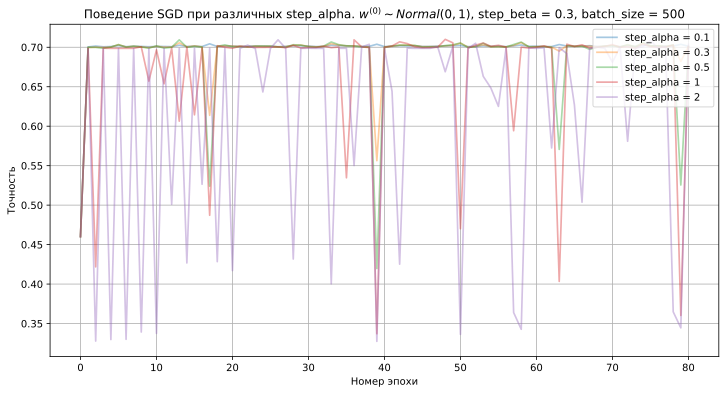

In [45]:
pyplot.figure(figsize=(12, 6))
plt.title("Поведение SGD при различных step_alpha. $w^{(0)} \sim Normal(0, 1)$, step_beta = 0.3, batch_size = 500")
plt.ylabel("Точность")
plt.xlabel("Номер эпохи")
pyplot.grid(True)

weight=np.random.normal(loc=0, scale=1,size=X_train_matrix.shape[1])
for alpha in [0.1, 0.3, 0.5, 1, 2]:
    grad_desc = SGDClassifier('binary_logistic', l2_coef=1, batch_size = 500, step_alpha=alpha, step_beta=0.3, max_iter=80, tolerance = 0.0000000001, random_seed=153)
    history = grad_desc.fit(X_train_matrix, y_train, w_0=weight, trace=True)
    prediction = grad_desc.predict(X_test_matrix)
    plt.plot(np.arange(81), history["accuracy"], label=f"step_alpha = {alpha}", linewidth=1.7, alpha=0.4)
    plt.legend(loc="upper right")
plt.savefig('8.pdf', bbox_inches='tight')
plt.show()

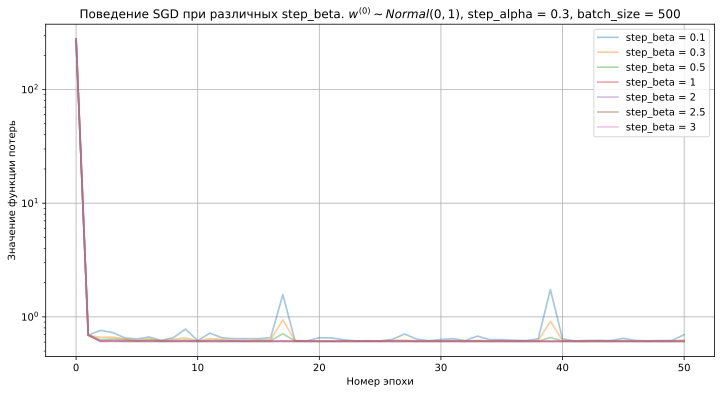

In [46]:
from matplotlib import pyplot as plt
pyplot.figure(figsize=(12, 6))
plt.title("Поведение SGD при различных step_beta. $w^{(0)} \sim Normal(0, 1)$, step_alpha = 0.3, batch_size = 500")
plt.ylabel("Значение функции потерь")
plt.xlabel("Номер эпохи")
plt.yscale('log')
pyplot.grid(True)

weight=np.random.normal(loc=0, scale=1,size=X_train_matrix.shape[1])
for beta in [0.1, 0.3, 0.5, 1, 2, 2.5, 3]:
    grad_desc = SGDClassifier('binary_logistic', l2_coef=1, batch_size = 500, step_alpha=0.3, step_beta=beta, max_iter=50, tolerance = 0.0000000001)
    history = grad_desc.fit(X_train_matrix, y_train, w_0=weight, trace=True)
    prediction = grad_desc.predict(X_test_matrix)
    plt.plot(np.arange(51), history["func"], label=f"step_beta = {beta}", linewidth=1.7, alpha=0.4)
    plt.legend(loc="upper right")
plt.savefig('9.pdf', bbox_inches='tight')
plt.show()

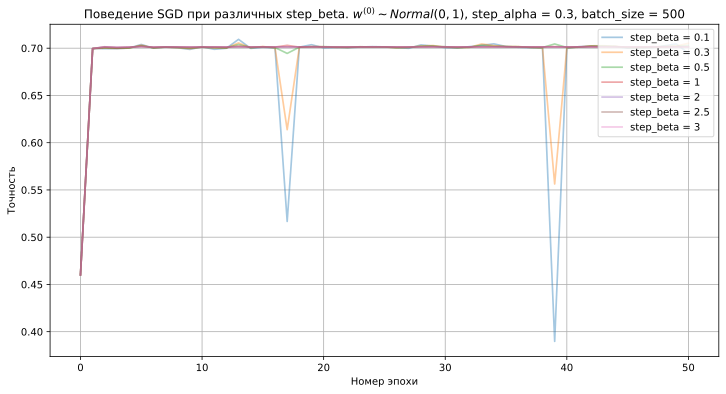

In [47]:
pyplot.figure(figsize=(12, 6))
plt.title("Поведение SGD при различных step_beta. $w^{(0)} \sim Normal(0, 1)$, step_alpha = 0.3, batch_size = 500")
plt.ylabel("Точность")
plt.xlabel("Номер эпохи")
pyplot.grid(True)

weight=np.random.normal(loc=0, scale=1,size=X_train_matrix.shape[1])
for beta in [0.1, 0.3, 0.5, 1, 2, 2.5, 3]:
    grad_desc = SGDClassifier('binary_logistic', l2_coef=1, batch_size = 500, step_alpha=0.3, step_beta=beta, max_iter=50, tolerance = 0.0000000001)
    history = grad_desc.fit(X_train_matrix, y_train, w_0=weight, trace=True)
    prediction = grad_desc.predict(X_test_matrix)
    plt.plot(np.arange(51), history["accuracy"], label=f"step_beta = {beta}", linewidth=1.7, alpha=0.4)
    plt.legend(loc="upper right")
plt.savefig('10.pdf', bbox_inches='tight')
plt.show()

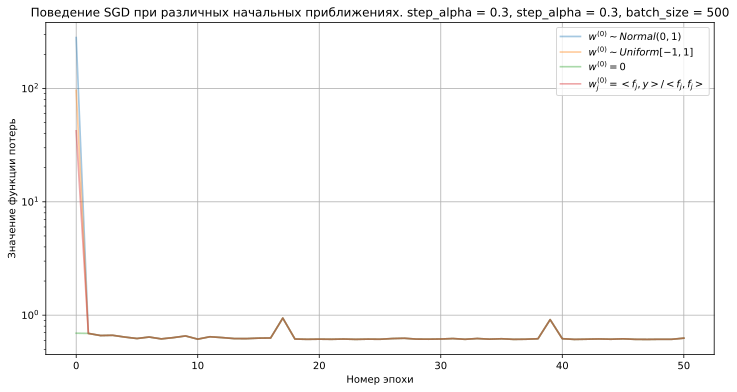

In [48]:
pyplot.figure(figsize=(12, 6))
plt.title("Поведение SGD при различных начальных приближениях. step_alpha = 0.3, step_alpha = 0.3, batch_size = 500")
plt.ylabel("Значение функции потерь")
plt.xlabel("Номер эпохи")
plt.yscale('log')
pyplot.grid(True)

grad_desc = SGDClassifier('binary_logistic', l2_coef=1, batch_size = 500, step_alpha=0.3, step_beta=0.3, max_iter=50, tolerance = 0.0000000001)
history = grad_desc.fit(X_train_matrix, y_train, w_0=np.random.normal(loc=0, scale=1,size=X_train_matrix.shape[1]), trace=True)
prediction = grad_desc.predict(X_test_matrix)
plt.plot(np.arange(51), history["func"], label="$w^{(0)} \sim Normal(0, 1)$", linewidth=1.7, alpha=0.4)
plt.legend(loc="upper right")

grad_desc = SGDClassifier('binary_logistic', l2_coef=1, batch_size = 500, step_alpha=0.3, step_beta=0.3, max_iter=50, tolerance = 0.0000000001)
history = grad_desc.fit(X_train_matrix, y_train, w_0=np.random.uniform(low=-1, high=1,size=X_train_matrix.shape[1]), trace=True)
prediction = grad_desc.predict(X_test_matrix)
plt.plot(np.arange(51), history["func"], label="$w^{(0)} \sim Uniform[-1, 1]$", linewidth=1.7, alpha=0.4)
plt.legend(loc="upper right")

grad_desc = SGDClassifier('binary_logistic', l2_coef=1, batch_size = 500, step_alpha=0.3, step_beta=0.3, max_iter=50, tolerance = 0.0000000001)
history = grad_desc.fit(X_train_matrix, y_train, w_0=np.zeros(X_train_matrix.shape[1]), trace=True)
prediction = grad_desc.predict(X_test_matrix)
plt.plot(np.arange(51), history["func"], label="$w^{(0)} = 0$", linewidth=1.7, alpha=0.4)
plt.legend(loc="upper right")

grad_desc = SGDClassifier('binary_logistic', l2_coef=1, batch_size = 500, step_alpha=0.3, step_beta=0.3, max_iter=50, tolerance = 0.0000000001)
weight=np.zeros(X_train_matrix.shape[1])
for j in range(X_train_matrix.shape[1]):
  weight[j] = np.dot(X_train_matrix[:, j].toarray().T[0], y_train) / np.dot(X_train_matrix[:, j].toarray().T[0], X_train_matrix[:, j].toarray().T[0])
history = grad_desc.fit(X_train_matrix, y_train, w_0=weight, trace=True)
prediction = grad_desc.predict(X_test_matrix)
plt.plot(np.arange(51), history["func"], label="$w^{(0)}_j = <f_j, y> / <f_j, f_j>$", linewidth=1.7, alpha=0.4)
plt.legend(loc="upper right")

plt.savefig('11.pdf', bbox_inches='tight')
plt.show()

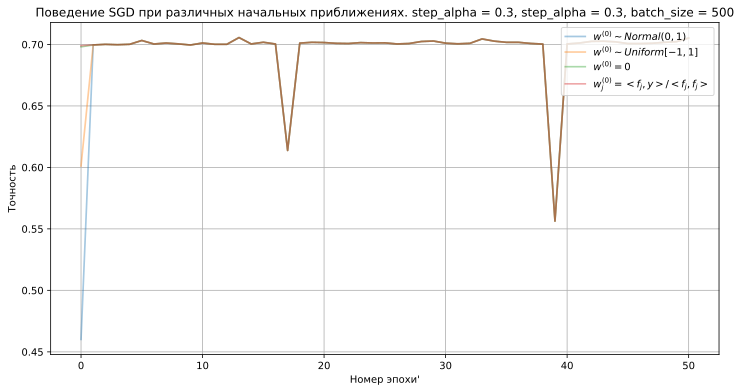

In [49]:
from matplotlib import pyplot as plt
pyplot.figure(figsize=(12, 6))
plt.title("Поведение SGD при различных начальных приближениях. step_alpha = 0.3, step_alpha = 0.3, batch_size = 500")
plt.ylabel("Точность")
plt.xlabel("Номер эпохи'")
# plt.yscale('log')
pyplot.grid(True)

loss = []
accuracy = []

grad_desc = SGDClassifier('binary_logistic', l2_coef=1, batch_size = 500, step_alpha=0.3, step_beta=0.3, max_iter=50, tolerance = 0.0000000001)
history = grad_desc.fit(X_train_matrix, y_train, w_0=np.random.normal(loc=0, scale=1,size=X_train_matrix.shape[1]), trace=True)
prediction = grad_desc.predict(X_test_matrix)
plt.plot(np.arange(51), history["accuracy"], label="$w^{(0)} \sim Normal(0, 1)$", linewidth=1.7, alpha=0.4)
plt.legend(loc="upper right")

grad_desc = SGDClassifier('binary_logistic', l2_coef=1, batch_size = 500, step_alpha=0.3, step_beta=0.3, max_iter=50, tolerance = 0.0000000001)
history = grad_desc.fit(X_train_matrix, y_train, w_0=np.random.uniform(low=-1, high=1,size=X_train_matrix.shape[1]), trace=True)
prediction = grad_desc.predict(X_test_matrix)
plt.plot(np.arange(51), history["accuracy"], label="$w^{(0)} \sim Uniform[-1, 1]$", linewidth=1.7, alpha=0.4)
plt.legend(loc="upper right")

grad_desc = SGDClassifier('binary_logistic', l2_coef=1, batch_size = 500, step_alpha=0.3, step_beta=0.3, max_iter=50, tolerance = 0.0000000001)
history = grad_desc.fit(X_train_matrix, y_train, w_0=np.zeros(X_train_matrix.shape[1]), trace=True)
prediction = grad_desc.predict(X_test_matrix)
plt.plot(np.arange(51), history["accuracy"], label="$w^{(0)} = 0$", linewidth=1.7, alpha=0.4)
plt.legend(loc="upper right")

grad_desc = SGDClassifier('binary_logistic', l2_coef=1, batch_size = 500, step_alpha=0.3, step_beta=0.3, max_iter=50, tolerance = 0.0000000001)
weight=np.zeros(X_train_matrix.shape[1])
for j in range(X_train_matrix.shape[1]):
  weight[j] = np.dot(X_train_matrix[:, j].toarray().T[0], y_train) / np.dot(X_train_matrix[:, j].toarray().T[0], X_train_matrix[:, j].toarray().T[0])
history = grad_desc.fit(X_train_matrix, y_train, w_0=weight, trace=True)
prediction = grad_desc.predict(X_test_matrix)
plt.plot(np.arange(51), history["accuracy"], label="$w^{(0)}_j = <f_j, y> / <f_j, f_j>$", linewidth=1.7, alpha=0.4)
plt.legend(loc="upper right")

plt.savefig('12.pdf', bbox_inches='tight')
plt.show()

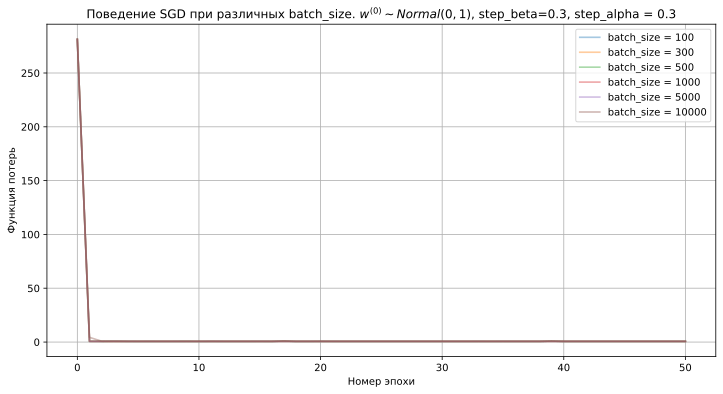

In [53]:
pyplot.figure(figsize=(12, 6))
plt.title("Поведение SGD при различных batch_size. $w^{(0)} \sim Normal(0, 1)$, step_beta=0.3, step_alpha = 0.3")
plt.ylabel("Функция потерь")
plt.xlabel("Номер эпохи")
pyplot.grid(True)

weight=np.random.normal(loc=0, scale=1,size=X_train_matrix.shape[1])
for batch in [100, 300, 500, 1000, 5000, 10000]:
    grad_desc = SGDClassifier('binary_logistic', l2_coef=1, batch_size = batch, step_alpha=0.3, step_beta=0.3, max_iter=50, tolerance = 0.0000000001)
    history = grad_desc.fit(X_train_matrix, y_train, w_0=weight, trace=True)
    prediction = grad_desc.predict(X_test_matrix)
    plt.plot(np.arange(51), history["func"], label=f"batch_size = {batch}", linewidth=1.7, alpha=0.4)
    plt.legend(loc="upper right")
plt.savefig('13.pdf', bbox_inches='tight')
plt.show()

/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))


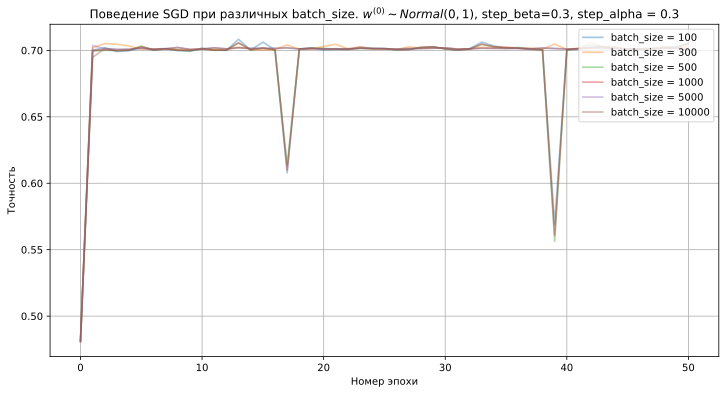

In [52]:
pyplot.figure(figsize=(12, 6))
plt.title("Поведение SGD при различных batch_size. $w^{(0)} \sim Normal(0, 1)$, step_beta=0.3, step_alpha = 0.3")
plt.ylabel("Точность")
plt.xlabel("Номер эпохи")
pyplot.grid(True)

weight=np.random.normal(loc=0, scale=1,size=X_train_matrix.shape[1])
for batch in [100, 300, 500, 1000, 5000, 10000]:
    grad_desc = SGDClassifier('binary_logistic', l2_coef=1, batch_size = batch, step_alpha=0.3, step_beta=0.3, max_iter=50, tolerance = 0.0000000001)
    history = grad_desc.fit(X_train_matrix, y_train, w_0=weight, trace=True)
    prediction = grad_desc.predict(X_test_matrix)
    plt.plot(np.arange(51), history["accuracy"], label=f"batch_size = {batch}", linewidth=1.7, alpha=0.4)
    plt.legend(loc="upper right")
plt.savefig('14.pdf', bbox_inches='tight')
plt.show()

In [103]:
# Задание 7
import nltk
from nltk import WordNetLemmatizer
#  подберём коэффициент регуляризации

from sklearn.model_selection import train_test_split
max_ = 0
answer = 0
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train_matrix, y_train, stratify=y_train, train_size=35000, random_state=333)
for i in np.logspace(-10, -0, num=50):
  model = SGDClassifier('binary_logistic', l2_coef=i, step_beta=3, batch_size=30)
  model.fit(X_train2, y_train2, w_0=np.zeros(X_train_matrix.shape[1]))
  if accuracy_score(y_test2, model.predict(X_test2)) > max_:
    max_ = accuracy_score(y_test2, model.predict(X_test2))
    answer = i
print(answer, max_)

/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/4197558863.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))
/var/folde

5.1794746792312125e-05 0.819471308833011


In [105]:
print(X_train_matrix.shape)

(52061, 437)


In [99]:
# Изначальное состояние
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')



def only_letters_and_numbers(s):
    answer = ''
    for x in s:
        if x.isalnum():
            answer += x
        else:
            answer += ' '
    return answer

# перевод в нижний регистр
train.comment_text = train.comment_text.str.lower()
test.comment_text = test.comment_text.str.lower()

# замена не букв и не цифр на пробелы
for i in train.index:
    train["comment_text"][i] = only_letters_and_numbers(train["comment_text"][i])
for i in test.index:
    test["comment_text"][i] = only_letters_and_numbers(test["comment_text"][i])

y_train = 2 * train["is_toxic"] - 1
y_test = 2 * test["is_toxic"] - 1
y_train = y_train.values
y_test = y_test.values

vectorizer = CountVectorizer(max_df=0.99, min_df=0.01)
X_train_matrix = vectorizer.fit_transform(train["comment_text"])
X_test_matrix = vectorizer.transform(test["comment_text"])

/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/3573586504.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["comment_text"][i] = only_letters_and_numbers(train["comment_text"][i])
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/3573586504.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["comment_text"][i] = only_letters_and_numbers(test["comment_text"][i])


In [102]:
# Лемматизация и удаление стоп-слов
nltk.download("stopwords")
def l(s):
    model = nltk.stem.wordnet.WordNetLemmatizer()
    stops = nltk.corpus.stopwords.words("english")
    answer = ''
    for x in s:
        if x not in stops:
            answer += model.lemmatize(x)
    return answer
for i in train.index:
    train["comment_text"][i] = l(train["comment_text"][i])
for i in test.index:
    test["comment_text"][i] = l(test["comment_text"][i])
vectorizer = CountVectorizer(max_df=0.99, min_df=0.01)
X_train_matrix = vectorizer.fit_transform(train["comment_text"])
X_test_matrix = vectorizer.transform(test["comment_text"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ivanmorozov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/1454814952.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["comment_text"][i] = l(train["comment_text"][i])
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/1454814952.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["comment_text"][i] = l(test["comment_text"][i])


In [ ]:
# Изначальное состояние
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')



def only_letters_and_numbers(s):
    answer = ''
    for x in s:
        if x.isalnum():
            answer += x
        else:
            answer += ' '
    return answer

# перевод в нижний регистр
train.comment_text = train.comment_text.str.lower()
test.comment_text = test.comment_text.str.lower()

# замена не букв и не цифр на пробелы
for i in train.index:
    train["comment_text"][i] = only_letters_and_numbers(train["comment_text"][i])
for i in test.index:
    test["comment_text"][i] = only_letters_and_numbers(test["comment_text"][i])

y_train = 2 * train["is_toxic"] - 1
y_test = 2 * test["is_toxic"] - 1
y_train = y_train.values
y_test = y_test.values

In [134]:
#EXP 8
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [140]:
vectorizer = CountVectorizer(max_df=0.99, min_df=0.01)
X_train_tmp = vectorizer.fit_transform(train["comment_text"])
X_test_tmp = vectorizer.transform(test["comment_text"])
model = SGDClassifier('binary_logistic', l2_coef=0.00075, step_alpha=1, step_beta=3, batch_size=30)
start = time.time()
model.fit(X_train_tmp, y_train, w_0=np.zeros(X_train_tmp.shape[1]))
print(time.time()-start)
pred = model.predict(X_test_tmp)
print('CountVectorizer', 0.01, 0.99, accuracy_score(y_test, pred), X_train_tmp.shape[1])





/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/1676414869.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))


4.064272165298462
CountVectorizer 0.01 0.99 0.8098761849487328 437


In [129]:
vectorizer = CountVectorizer(max_df=0.97, min_df=0.03)
X_train_tmp = vectorizer.fit_transform(train["comment_text"])
X_test_tmp = vectorizer.transform(test["comment_text"])
model = SGDClassifier('binary_logistic', l2_coef=0.00075, step_alpha=1, step_beta=3, batch_size=30)
start = time.time()
model.fit(X_train_tmp, y_train, w_0=np.zeros(X_train_tmp.shape[1]))
print(time.time()-start)
pred = model.predict(X_test_tmp)
print('CountVectorizer', 0.03, 0.97, accuracy_score(y_test, pred), X_train_tmp.shape[1])

/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/1676414869.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))


2.8935248851776123
CountVectorizer 0.03 0.97 0.779647900947959 158


In [128]:
vectorizer = CountVectorizer(max_df=0.8, min_df=0.2)
X_train_tmp = vectorizer.fit_transform(train["comment_text"])
X_test_tmp = vectorizer.transform(test["comment_text"])
model = SGDClassifier('binary_logistic', l2_coef=0.00075, step_alpha=1, step_beta=3, batch_size=30)
start = time.time()
model.fit(X_train_tmp, y_train, w_0=np.zeros(X_train_tmp.shape[1]))
print(time.time()-start)
pred = model.predict(X_test_tmp)
print('CountVectorizer', 0.2, 0.8, accuracy_score(y_test, pred), X_train_tmp.shape[1])

1.2179129123687744
CountVectorizer 0.2 0.8 0.702070032888373 13


In [135]:
vectorizer = TfidfVectorizer(max_df=0.99, min_df=0.01, norm=None)
X_train_tmp = vectorizer.fit_transform(train["comment_text"])
X_test_tmp = vectorizer.transform(test["comment_text"])
model = SGDClassifier('binary_logistic', l2_coef=0.00075, step_alpha=1, step_beta=3, batch_size=30)
start = time.time()
model.fit(X_train_tmp, y_train, w_0=np.zeros(X_train_tmp.shape[1]))
print(time.time()-start)
pred = model.predict(X_test_tmp)
print('TfidfVectorizer', 0.01, 0.99, accuracy_score(y_test, pred), X_train_tmp.shape[1])

/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/1676414869.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))


11.857258081436157
TfidfVectorizer 0.01 0.99 0.7941091120139292 437


In [136]:
vectorizer = TfidfVectorizer(max_df=0.97, min_df=0.03, norm=None)
X_train_tmp = vectorizer.fit_transform(train["comment_text"])
X_test_tmp = vectorizer.transform(test["comment_text"])
model = SGDClassifier('binary_logistic', l2_coef=0.00075, step_alpha=1, step_beta=3, batch_size=30)
start = time.time()
model.fit(X_train_tmp, y_train, w_0=np.zeros(X_train_tmp.shape[1]))
print(time.time()-start)
pred = model.predict(X_test_tmp)
print('TfidfVectorizer', 0.03, 0.97, accuracy_score(y_test, pred), X_train_tmp.shape[1])

/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/1676414869.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))


1.7562057971954346
TfidfVectorizer 0.03 0.97 0.7787773263687366 158


In [137]:
vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.2, norm=None)
X_train_tmp = vectorizer.fit_transform(train["comment_text"])
X_test_tmp = vectorizer.transform(test["comment_text"])
model = SGDClassifier('binary_logistic', l2_coef=0.00075, step_alpha=1, step_beta=3, batch_size=30)
start = time.time()
model.fit(X_train_tmp, y_train, w_0=np.zeros(X_train_tmp.shape[1]))
print(time.time()-start)
pred = model.predict(X_test_tmp)
print('TfidfVectorizer', 0.2, 0.8, accuracy_score(y_test, pred), X_train_tmp.shape[1])

/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/1676414869.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))


1.893279790878296
TfidfVectorizer 0.2 0.8 0.7019733023795706 13


In [142]:
#EXP 9
# Изначальное состояние
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')



def only_letters_and_numbers(s):
    answer = ''
    for x in s:
        if x.isalnum():
            answer += x
        else:
            answer += ' '
    return answer

# перевод в нижний регистр
train.comment_text = train.comment_text.str.lower()
test.comment_text = test.comment_text.str.lower()

# замена не букв и не цифр на пробелы
for i in train.index:
    train["comment_text"][i] = only_letters_and_numbers(train["comment_text"][i])
for i in test.index:
    test["comment_text"][i] = only_letters_and_numbers(test["comment_text"][i])

y_train = 2 * train["is_toxic"] - 1
y_test = 2 * test["is_toxic"] - 1
y_train = y_train.values
y_test = y_test.values
vectorizer = CountVectorizer(max_df=0.99, min_df=0.01)
X_train_matrix = vectorizer.fit_transform(train["comment_text"])
X_test_matrix = vectorizer.transform(test["comment_text"])

/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/917462505.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["comment_text"][i] = only_letters_and_numbers(train["comment_text"][i])
/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/917462505.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["comment_text"][i] = only_letters_and_numbers(test["comment_text"][i])


In [144]:
# Лучший алгоритм
model = SGDClassifier('binary_logistic', l2_coef=0.00075, step_beta=3, batch_size=30)
model.fit(X_train_matrix, y_train, w_0=np.zeros(X_train_matrix.shape[1]))
pred = model.predict(X_test_matrix)
print(accuracy_score(y_test, pred))

/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/1676414869.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))


0.8406848520023216


In [150]:
count = 0
for i in range(len(y_test)):
  if y_test[i] != pred[i] and count < 10 and len(test["comment_text"][i]) < 20:
    count += 1
    print(y_test[i], pred[i], test["comment_text"][i])

-1 [1] you guys are sick 
-1 [1] bacteria is sicko
1 [-1] what a shit country
-1 [1] i like sex    
-1 [1] uhoris metrshy ohra
1 [-1] starfish is so gay
1 [-1] i am a dickhead
1 [-1] sam is a fag
1 [-1] i think you are gay
-1 [1]    anaheim ducks   


In [162]:
# ДОП

for i in range(1, 10):
  vectorizer = CountVectorizer(ngram_range=(1, i), min_df=0.001, max_df=0.1)
  X_train_tmp = vectorizer.fit_transform(train["comment_text"])
  X_test_tmp = vectorizer.transform(test["comment_text"])
  model = SGDClassifier('binary_logistic', l2_coef=0.00075, step_alpha=1, step_beta=3, batch_size=30)
  start = time.time()
  model.fit(X_train_tmp, y_train, w_0=np.zeros(X_train_tmp.shape[1]))
  print(time.time()-start)
  pred = model.predict(X_test_tmp)
  print(i, accuracy_score(y_test, pred), X_train_tmp.shape[1])

/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/1676414869.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))


7.3806540966033936
1 0.8746372605919908 3680


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/1676414869.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))


18.704938888549805
2 0.876330044496034 9056


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/1676414869.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))


18.028923988342285
3 0.875120913136003 10866


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/1676414869.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))


20.98821711540222
4 0.8750241826272006 11610


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/1676414869.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))


22.777233123779297
5 0.8750241826272006 12221


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/1676414869.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))


22.418877124786377
6 0.8750725478816018 12775


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/1676414869.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))


27.700589179992676
7 0.8750725478816018 13286


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/1676414869.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))


22.856280088424683
8 0.8749758173727994 13756


/var/folders/dg/hzy7hh_s4ds9lspj4d52_lf00000gn/T/ipykernel_14677/1676414869.py:69: RuntimeWarning: overflow encountered in exp
  denominator = (1 + np.exp(y.T * M))


24.413354873657227
9 0.8749758173727994 14198
